# 2D NUS Reconstruction

In [1]:
import time
import numpy as np
import nmrglue as ng
import MRAi_2D as ma
import Proc_2D as pr
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':25})

2024-09-25 04:40:11.782606: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-25 04:40:24.496873: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Define the path (direction) of the NUS spectrum process in pipe format and NUS list.
Here as an example, the path to US 2D H-N—HSQC spectrum of protein Ubiquitin is used. Then NUS spectrum is prepared based on the US and NUS list.
![US_NUS.png](Figs/US_NUS.png)

In [4]:
%%time
# Replace this path with your actual NUS table file.
NUS_table_Dirc = 'Trained_NN/NUS/NUS_tables/Small_9'
# Read the NUS table file.
NUS_table = []
with open(NUS_table_Dirc) as f:
    for line in f:
        NUS_table.append(int(line))

# Replace this path with your actual spectrum in nmrpipe format file.
spectrum_direction = "Spectra/Ubi.ft2"
# Read the file with nmrglue.
Dic , Ref = ng.pipe.read(spectrum_direction)
# Convert Ref spectrum to NUS spectrum with NUS table
NUS = pr.convertors.US_to_NUS(Ref,NUS_table)
# In case of NUS
#Dic , NUS = ng.pipe.read(spectrum_direction)

CPU times: user 19.7 ms, sys: 9.31 ms, total: 29 ms
Wall time: 39.3 ms


### Adjust the NUS reconstruction parameters
These can be modified based on the spectrum and specific reconstruction method.

In [3]:
%%time
#The size of protein: Small, Medium, Large
Protien_size = "Small"

#The reconstraction scheme: WNN-F, WNN-P, WNN-R
Method = "WNN-F"

#In the case of WNN-F, trained NUS tables are: S_0, S_1, ..., S_10
WNN_F = "S_9"

CPU times: user 5 μs, sys: 4 μs, total: 9 μs
Wall time: 15.7 μs


### Call the function with the default direction that runs the trained network for NUS reconstruction.
![NUS_MRAi.png](Figs/NUS_MRAi.png)

In [7]:
def NUS_Rec(Dic,NUS,NUS_table,DNN_dirc):
    # Inverse Pipe processing along the indirect dimension
    dic , nus = pr.pipe_generator.iFT_ID(Dic,NUS)
    # Perform VE (Virtual Echo) in the time domain and apply Fourier Transform
    VE = ma.convertors.US_VE(nus,128)
    # NUS Recostraction using MRAi
    pred = ma.Production.NUS_Rec(VE,NUS_table,len(NUS_table)/128,DNN_dirc)
    # Apply iFT along the indirect dimension and select time domain data along the direct dimension
    ft1 = np.zeros_like(nus)
    ft1[:min(int(pred.shape[0]),int(ft1.shape[0]))] = pred[:min(int(pred.shape[0]),int(ft1.shape[0]))]
    # Process along the indirect dimension
    _, WNN = pr.pipe_generator.FT_ID(dic,ft1)
    return WNN

In [8]:
%%time
# Path to the trained network model
DNN_dirc = "Trained_NN/NUS/"
DNN_dirc += Protien_size + '/' + Method +'/'
if Method == "WNN-F": DNN_dirc += WNN_F + '/'

# NUS Recostraction with MRAi
WNN = NUS_Rec(Dic,NUS,NUS_table,DNN_dirc)

64/64 [==============================] - 0s 1ms/step
CPU times: user 15.1 s, sys: 1.1 s, total: 16.2 s
Wall time: 16.3 s


### Plotting the spectra

CPU times: user 934 ms, sys: 7.53 ms, total: 942 ms
Wall time: 1.1 s


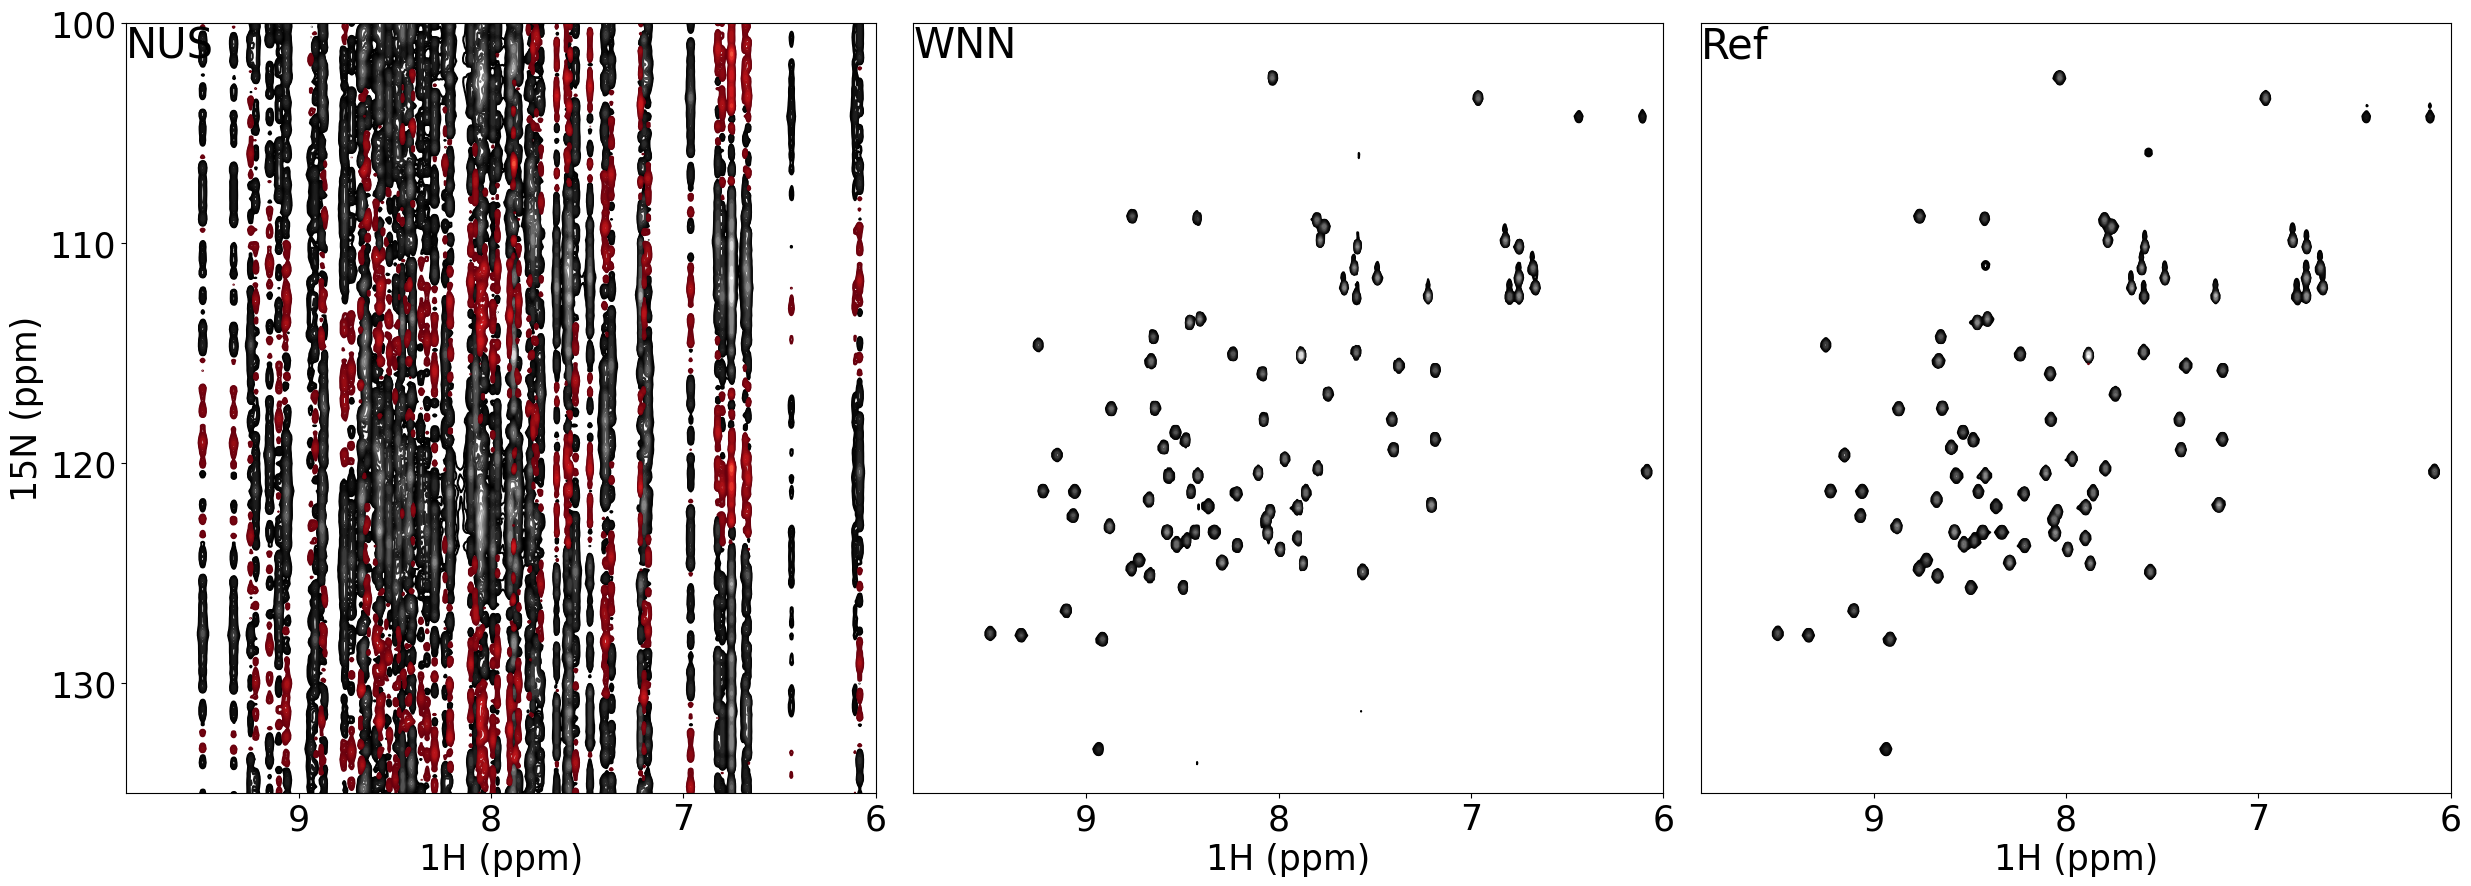

In [9]:
%%time
fig, ax = plt.subplots(1,3,figsize=(3*10,1*10))
cmap = [plt.cm.Greys_r,plt.cm.Reds_r]    #[+,-] contour map (colors to use for contours)
contour = [0.025,1.3,15]         #[contour level start value, scaling factor between contour level]
lim = [9.9,6,135,100]                 #[xlim from,xlim to,ylim from,ylim to]

pr.PLOTS.subp(ax[0],Dic,NUS/np.max(NUS), "NUS",contour,cmap,lim)
pr.PLOTS.subp(ax[1],Dic,WNN/np.max(Ref), "WNN",contour,cmap,lim)
pr.PLOTS.subp(ax[2],Dic,Ref/np.max(Ref), "Ref",contour,cmap,lim)

ax[1].axes.yaxis.set_visible(False)
ax[2].axes.yaxis.set_visible(False)

plt.subplots_adjust(wspace=0.05, hspace=0.05)